In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

random_seed = 123
np.random.seed(random_seed)

# 1. Reading the data

Histone modifications play an important role in affecting gene regulation. Specific histone modifications at specific locations in or near the gene can alter the expression of genes. Predicting gene expression from histone modification signals is a widely studied research topic.

In this competition you will predict gene expression levels (low=0, high=1) based on the presence of histone modifications at specific locations in the gene. You will try to find the model that learns the true underlying model best.

For each gene a region of 10.000bp around the transcription start site of the gene is extracted (5000bp upstream and 5000bp downstream). This region is binned in 100 bins of 100bp. For each bin five core histone modification marks are counted [1].

The dataset is compiled from the "E047" (Primary T CD8+ naive cells from peripheral blood) celltype from Roadmap Epigenomics Mapping Consortium (REMC) database.

[1] Kundaje, A. et al. Integrative analysis of 111 reference human epige-
nomes. Nature, 518, 317–330, 2015.


We start by loading the Pandas library and reading the datasets into Pandas DataFrames:

In [2]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data_test.csv")

Let's look at the first 5 rows of the trainset:

In [3]:
train.head(5)

,GeneId,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,...,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99,Label
0,7008,1,1,2,1,3,1,2,5,0,...,11,15,5,2,2,10,12,2,2,1
1,9839,0,0,1,1,0,2,0,2,0,...,1,0,0,0,1,1,0,0,0,1
2,11972,7,3,1,1,1,4,2,1,1,...,1,0,2,0,1,1,1,1,0,0
3,14705,4,2,4,1,3,0,2,1,1,...,1,2,4,2,4,3,0,0,0,0
4,12058,1,1,2,0,8,0,2,1,1,...,1,2,2,1,0,1,1,1,0,1


There is a column called `GeneId` that identifies the gene. This column should not be used as a feature. 

The label for each datapoint is in the `Label` column.

In [4]:
train_ids = train.pop("GeneId")
train_labels = train.pop("Label")

Now `train` contains the feature columns only.

Let's look at the number datapoints in each class:

In [5]:
train_labels.value_counts()

1    5250
0    5186
Name: Label, dtype: int64

Let's look at `test`:

In [6]:
test.head(5)

,GeneId,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,...,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
0,5222,2,2,7,2,0,3,2,9,2,...,0,2,1,1,0,0,3,1,1,1
1,891,1,2,0,0,1,0,4,1,2,...,3,2,2,2,0,4,2,5,2,1
2,7219,1,1,2,4,4,2,2,1,1,...,1,3,1,1,0,0,1,1,1,0
3,7225,1,5,2,4,1,0,8,3,4,...,0,2,1,1,2,1,1,0,2,0
4,9432,1,16,3,2,2,2,7,0,4,...,0,1,2,0,1,1,1,1,2,1


This is a blind test so the `Label` column is not available in the testset. The testset does contain the `GeneId` column that is needed to send your predictions to the Kaggle website.


In [7]:
test_index_col = test.pop("GeneId")

We can get some general statistics about the trainset using the DataFrame `.describe()` function:

In [35]:
train.describe().transpose().sample(10)

,count,mean,std,min,25%,50%,75%,max
H3K9me3_40,10436.0,7.940878,14.110178,0.0,1.0,2.0,8.0,118.0
H3K36me3_93,10436.0,2.465025,3.886855,0.0,0.0,1.0,3.0,38.0
H3K9me3_77,10436.0,2.276351,5.757776,0.0,0.0,1.0,2.0,110.0
H3K4me1_78,10436.0,1.621790,1.932007,0.0,0.0,1.0,2.0,33.0
H3K4me1_47,10436.0,1.246167,1.368780,0.0,0.0,1.0,2.0,17.0
H3K4me1_45,10436.0,1.293312,1.387920,0.0,0.0,1.0,2.0,21.0
H3K27me3_23,10436.0,1.111058,1.362876,0.0,0.0,1.0,2.0,26.0
H3K36me3_17,10436.0,2.737447,4.139570,0.0,0.0,1.0,3.0,42.0
H3K9me3_98,10436.0,1.800882,4.797043,0.0,0.0,1.0,2.0,99.0
H3K4me1_83,10436.0,1.698735,2.151627,0.0,0.0,1.0,2.0,77.0


# 2. Data pre-processing




We can use the Pandas `boxplot()` function to plot the feature values:

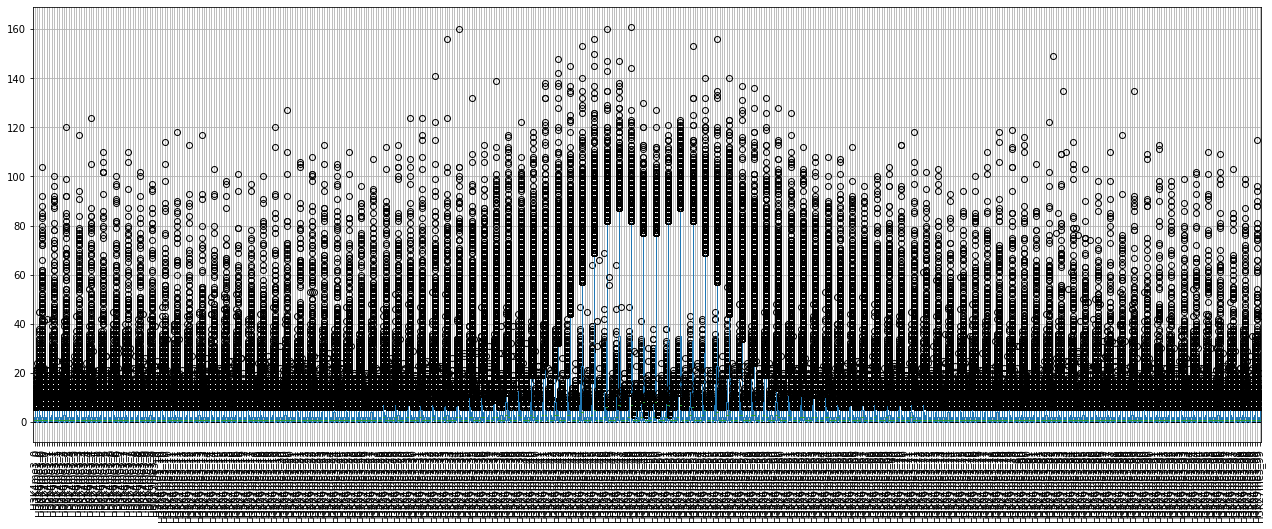

In [36]:
plt.figure(figsize=(22,8))
train.boxplot()
plt.xticks(rotation=90)
plt.show()

Let's plot these for each hisotone mark:

In [10]:
marks = {}
for m in train.columns:
  marks[m.split("_")[0]] = True
marks = list(marks.keys())
marks

['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']

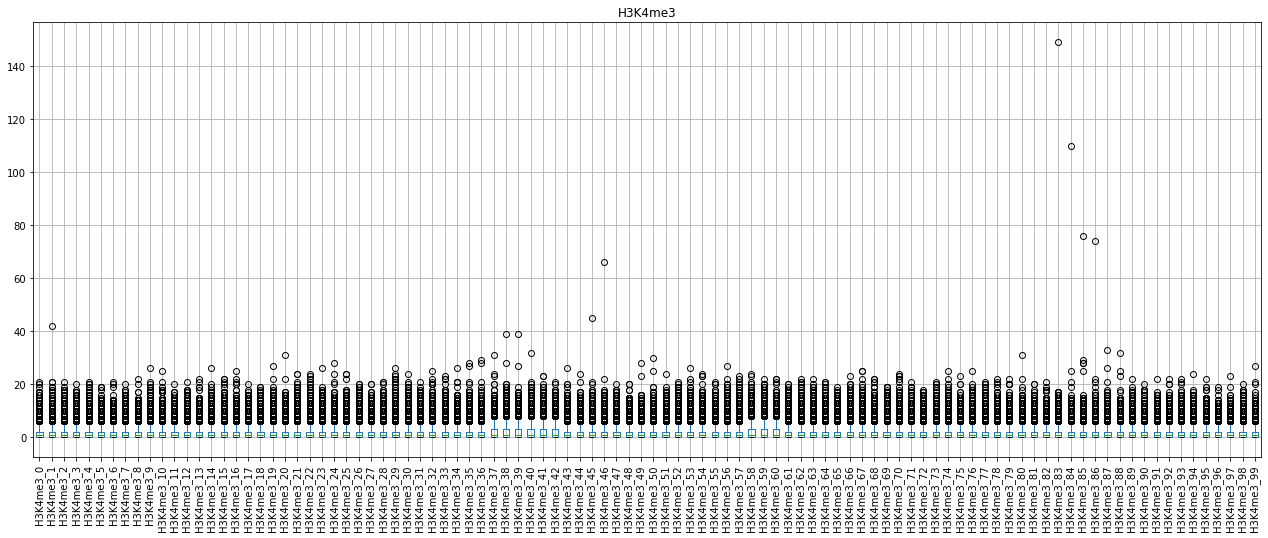

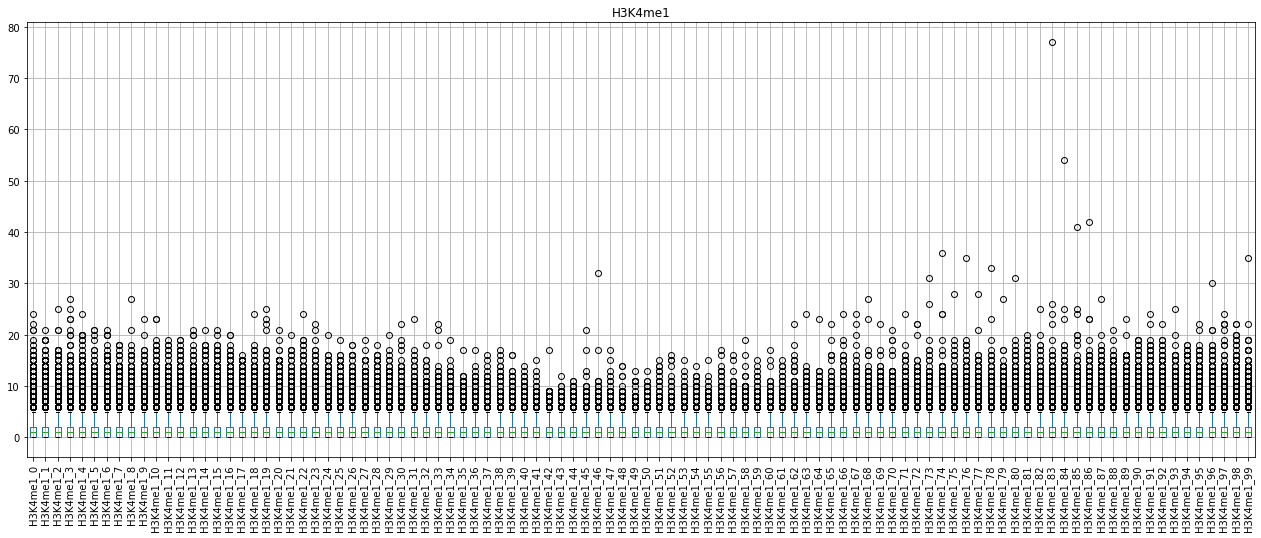

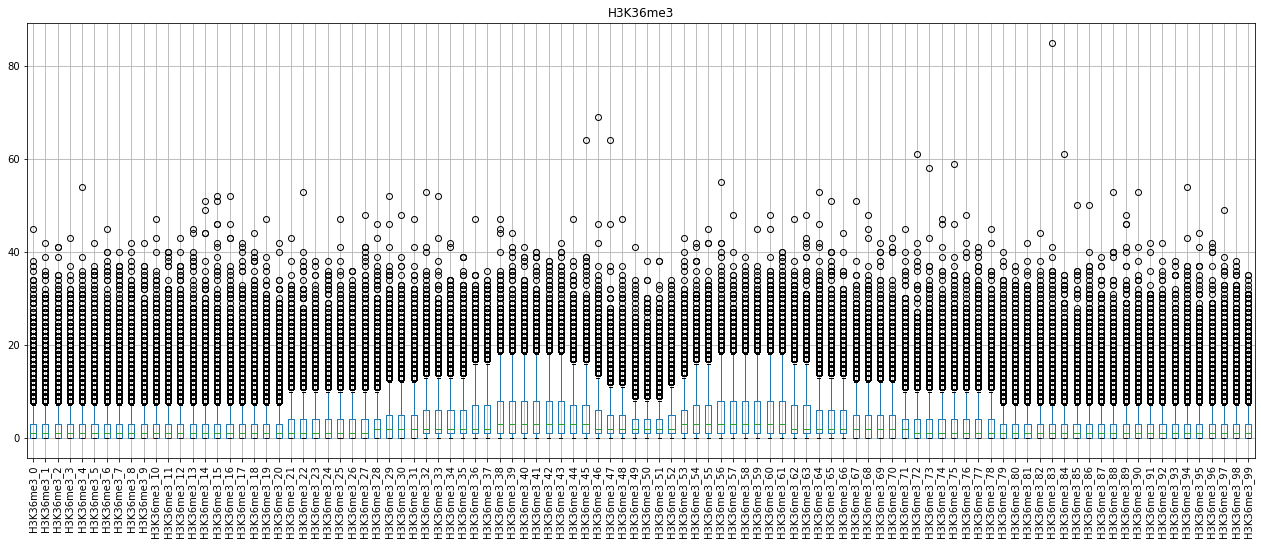

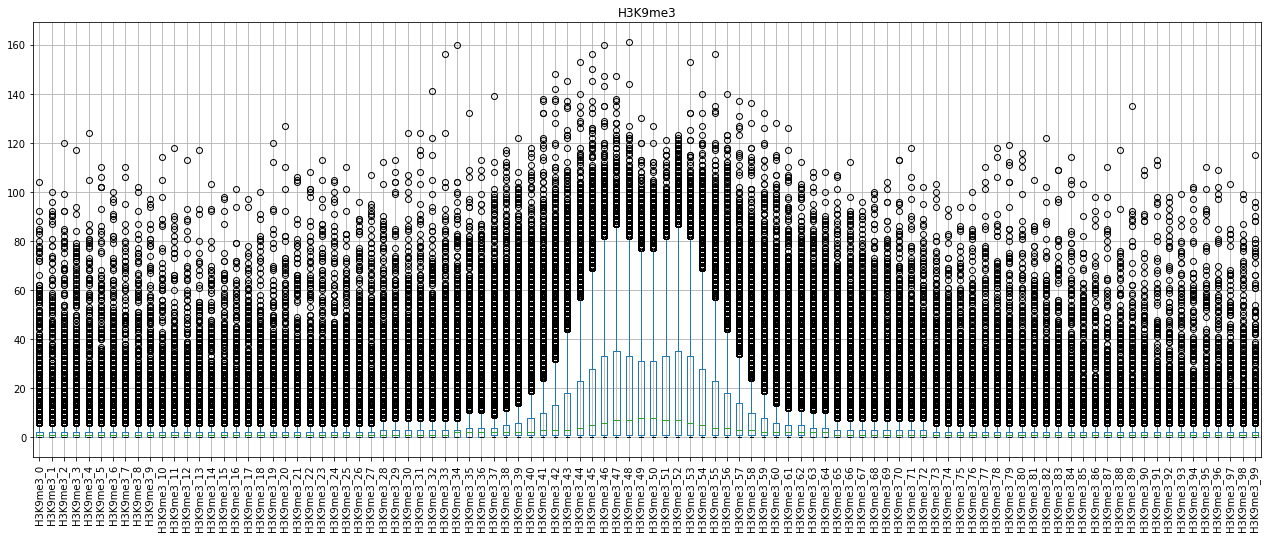

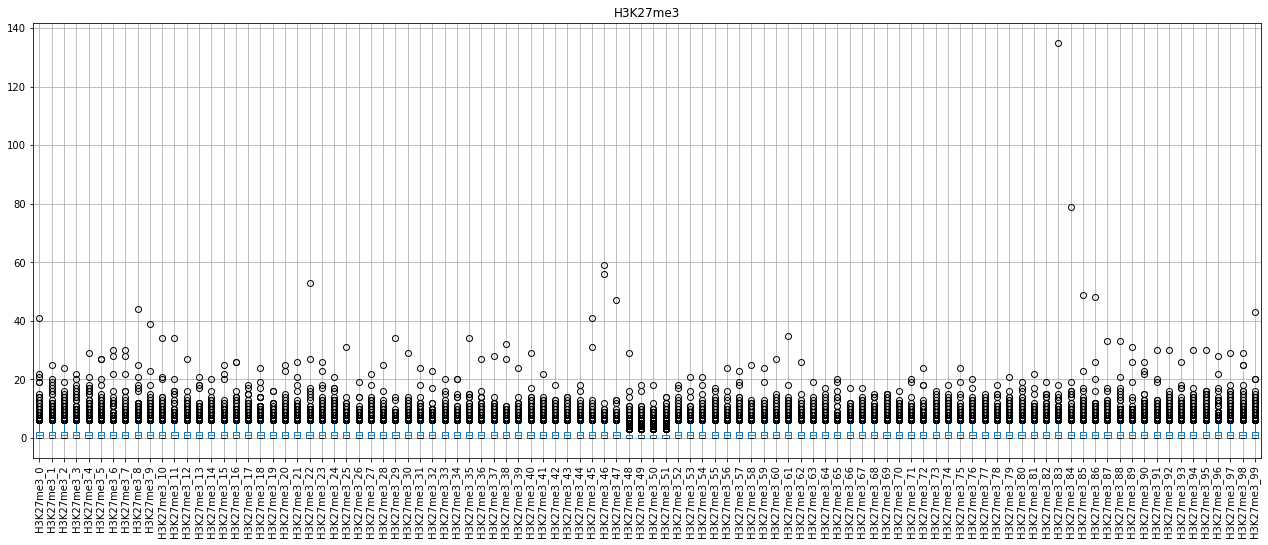

In [39]:
for mark in marks:
    cols = []
    for m in train.columns:
        if mark in m:
            cols.append(m)
    plt.figure(figsize=(22,8))    
    train[cols].boxplot()
    plt.title(mark)
    plt.xticks(rotation=90)    
    plt.show()

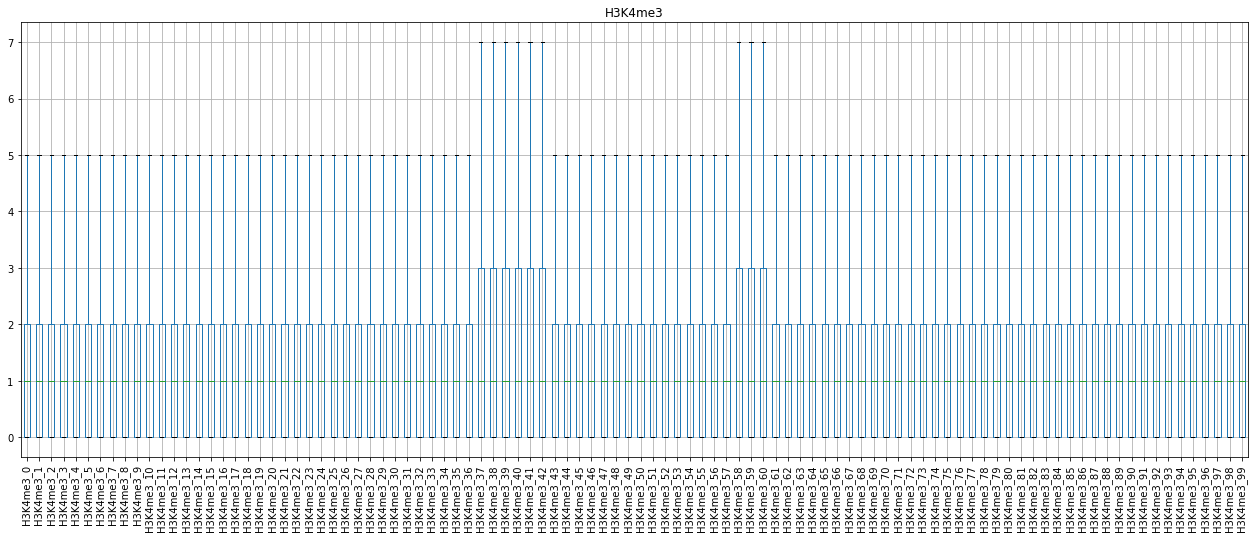

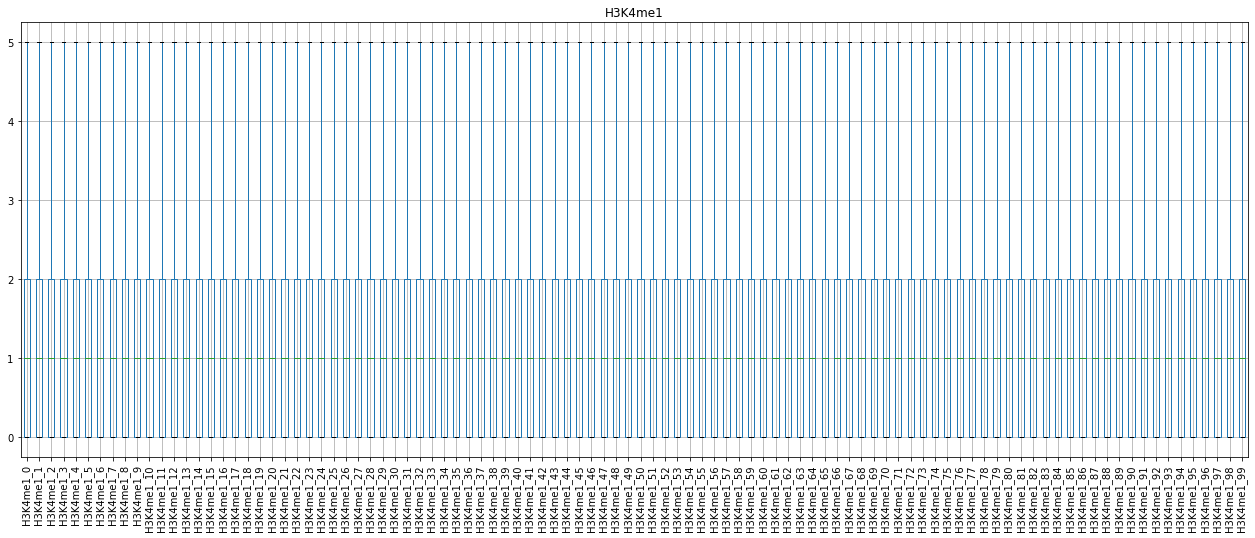

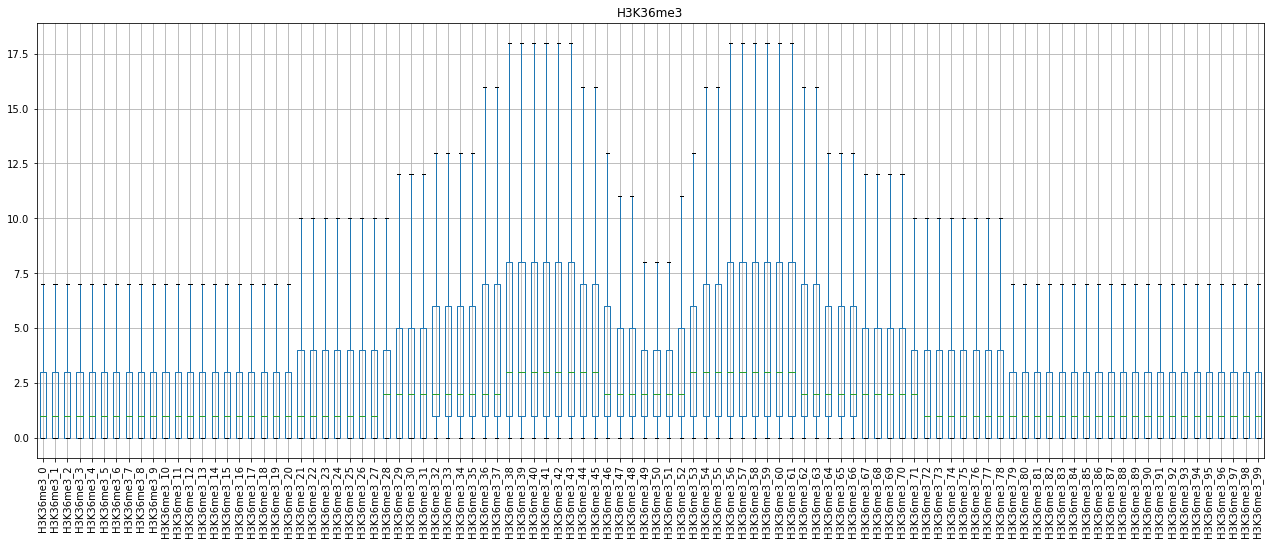

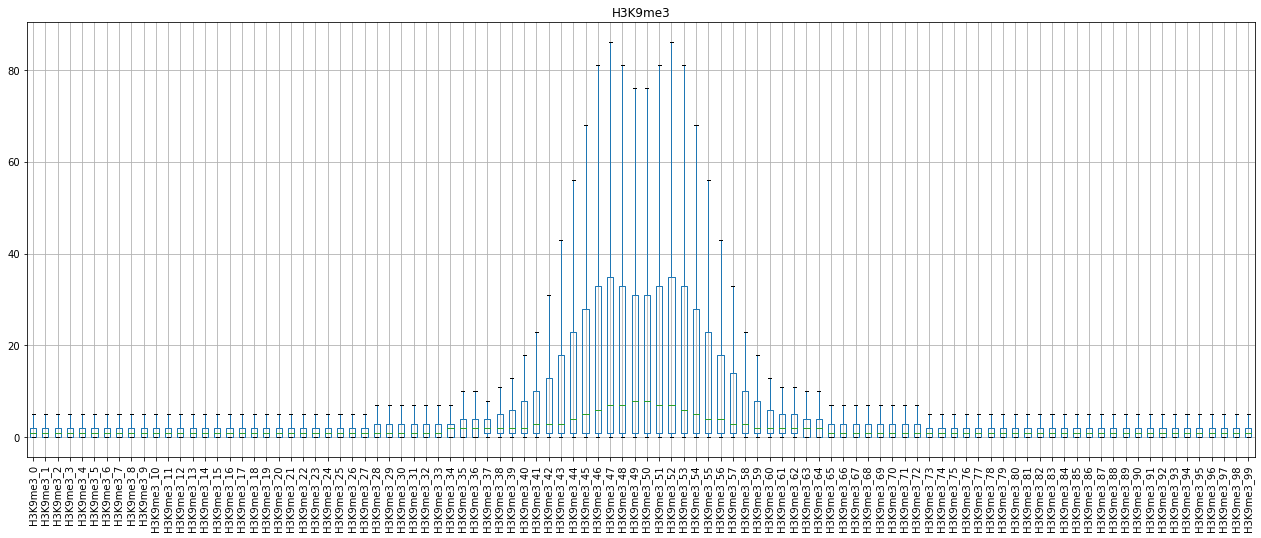

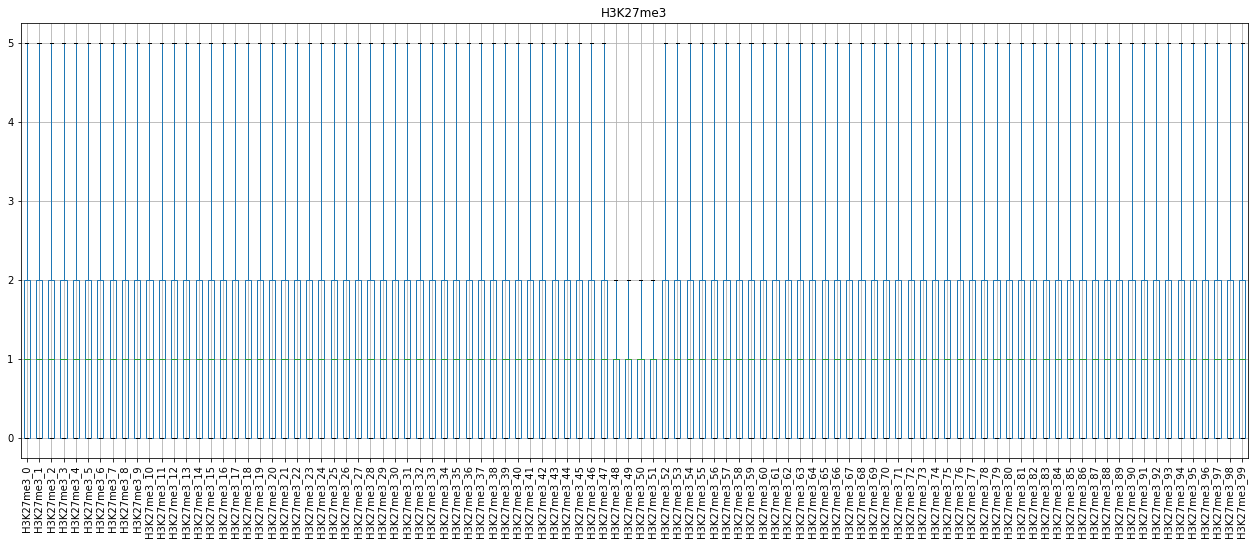

In [40]:
for mark in marks:
    cols = []
    for m in train.columns:
        if mark in m:
            cols.append(m)
    plt.figure(figsize=(22,8))    
    train[cols].boxplot(showfliers=False)
    plt.title(mark)
    plt.xticks(rotation=90)    
    plt.show()

# 3. Building a decision tree

The scikit-learn `DecisionTreeClassifier` class computes a decision tree predictive model from a dataset. 

To get all the options for learning you can simply type: 

In [14]:
from sklearn.tree import DecisionTreeClassifier
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choos

You notice that there are many (hyper)parameters to set. These influence the complexity of the model. An important such parameter is the `max_depth` that sets a limit on how deep a decision tree can become. 

Let's create a decision tree model with `max_depth=3`:

In [15]:
cls_DT = DecisionTreeClassifier(max_depth=3)

This creates a decision tree model with default values for the other hyperparameters:

In [16]:
cls_DT

DecisionTreeClassifier(max_depth=3)

Now we can fit the trainset in just one line of code:

In [17]:
cls_DT.fit(train_norm,train_labels)

DecisionTreeClassifier(max_depth=3)

Let's see how well the decision tree performs on the trainset:

In [18]:
from sklearn.metrics import accuracy_score

predictions = cls_DT.predict(train_norm)
print("Accuracy: %f"%(accuracy_score(predictions, train_labels)))

Accuracy: 0.825125


These are the predictions for the first 100 data points:

In [19]:
predictions[0:100]

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

For the Kaggle competition your predictions are not evaluated by accuracy, but by log-loss:

$$ - \frac{1}{N} \sum_{i=1}^N [y_{i} \log \, p_{i} + (1 - y_{i}) \log \, (1 - p_{i})],$$

where $N$ is the number of datapoints, $y_i$ is the label of datapoint $i$, and $p_i$ is the prediction of the model expressed as a probability.

Let's compute the log-loss:


In [20]:
from sklearn.metrics import log_loss

print("Log-loss: %f"%log_loss(train_labels,predictions))

Log-loss: 6.040057


This is a very high log-loss (note that we want the log-loss the be as close to zero as possible).

The reason is that we don't actually provide probabilities but just the classes 0 and 1. Any error will be punished with a very high contribution to the log-loss. Therefor, we should predict class probabilities rather than just classes. 

Decision trees allow us to do that:

In [21]:
predictions = cls_DT.predict_proba(train_norm)

print("Log-loss: %f"%log_loss(train_labels,predictions))

Log-loss: 0.452246


Now the log-loss is much smaller.

The following code plots the fitted decision tree `cls` as a `tree.png` file:

In [22]:
"""
from sklearn import tree
from io import StringIO
from IPython.display import Image, display
import pydotplus

out = StringIO()
tree.export_graphviz(cls_DT, out_file=out)
graph=pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png("tree.png")
"""

'\nfrom sklearn import tree\nfrom io import StringIO\nfrom IPython.display import Image, display\nimport pydotplus\n\nout = StringIO()\ntree.export_graphviz(cls_DT, out_file=out)\ngraph=pydotplus.graph_from_dot_data(out.getvalue())\ngraph.write_png("tree.png")\n'

# 4. Kaggle evaluation

Let's make a Kaggle submission:

In [23]:
#code for submission
predictions_test = cls_DT.predict_proba(test)

out_tmp = pd.DataFrame()
out_tmp["GeneId"] = test_index_col
out_tmp["eyeDetection"] = predictions_test[:,1]
out_tmp.to_csv("submission_DT.csv",index=False)

How does the model perform on the testset?

# 5. Hyperparamters

For our first submission we set the hyperparameter `max_depth=3`. Other values might result in lower log-loss on the testset. 

Since we don't have the testset labels we can only check this on the public leaderboard, which we can/should not do!

So, we need to create our own testset (**not seen during training!**) with known class labels.

Scikit-learn offers many options to do this. One of them is the `train_test_split` function:

In [24]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                  test_size=.2, random_state=random_seed)

#train fold
print(train_X.shape)
print(train_y.shape)
#validation fold
print(val_X.shape)
print(val_y.shape)

(8348, 500)
(8348,)
(2088, 500)
(2088,)


Fit a decision tree model with `max_depth=14` default paramters on the `train_X` data set.

In [25]:
#solution

What is the accuracy and log-loss on `train_X`? 

In [26]:
#solution

What is the accuracy and log-loss on `val_X`?

In [27]:
#solution

What do you see?


The following code evaluates different values for this hyperparameter.

In [28]:
for maxdepth in range(1,20,1):
    cls = DecisionTreeClassifier(max_depth=maxdepth)
    cls.fit(train_X,train_y)
    predictions_train = cls.predict(train_X)
    predictions_val = cls.predict(val_X)
    predictions_train_prob = cls.predict_proba(train_X)[:,1]
    predictions_val_prob = cls.predict_proba(val_X)[:,1]
    print("%i (%f) %f (%f) %f"%(maxdepth,
                                accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y),
                                log_loss(train_y,predictions_train_prob),log_loss(val_y,predictions_val_prob)))

1 (0.787254) 0.795019 (0.517571) 0.507348
2 (0.810134) 0.811782 (0.484475) 0.479824
3 (0.822353) 0.818008 (0.456446) 0.461147
4 (0.825587) 0.818487 (0.427133) 0.456196
5 (0.840920) 0.819444 (0.401390) 0.607499
6 (0.851102) 0.826628 (0.378458) 0.761725
7 (0.865357) 0.824713 (0.355032) 0.920680
8 (0.879492) 0.827107 (0.326819) 1.092926
9 (0.893268) 0.817529 (0.294726) 1.615001
10 (0.911116) 0.809387 (0.257969) 2.256964
11 (0.925252) 0.816571 (0.221795) 2.878067
12 (0.938548) 0.808429 (0.195713) 3.474935
13 (0.946814) 0.811303 (0.171509) 3.873934
14 (0.954360) 0.812739 (0.153863) 4.190647
15 (0.960350) 0.808429 (0.139453) 4.649229
16 (0.964303) 0.810824 (0.123946) 4.790524
17 (0.966219) 0.800287 (0.118728) 5.353617
18 (0.970292) 0.798372 (0.106601) 5.556673
19 (0.972688) 0.802682 (0.098472) 5.486172


What do you see?

So, we have split the data into a train- and validationset. We can of course split the data in many different ways (different random seeds) resulting in different train- and validationsets.

Let's try 5 different random seeds:

In [29]:
for run in range(5):
  train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                  test_size=.8, random_state=run)
  min_m = 100
  best = None
  for maxdepth in range(1,20,1):
      cls = DecisionTreeClassifier(max_depth=maxdepth)
      cls.fit(train_X,train_y)
      predictions_val_prob = cls.predict_proba(val_X)[:,1]
      m = log_loss(val_y,predictions_val_prob)
      if m < min_m:
        min_m = m
        best = maxdepth
  print("%i %f"%(best,min_m))

2 0.489871
2 0.501669
3 0.477714
2 0.491435
3 0.479280


What do you see?

The solution is to run several train-validations splits and average the performance.

One popular method is cross-validation that uses each datapoint once as a testpoint.

It works as follows:
<br/>
<br/>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png"/>
<br/>
<br/>

It is easy to run this in Scikit-learn:



In [30]:
from sklearn.model_selection import cross_val_predict

for maxdepth in range(1,10,1):
    cls = DecisionTreeClassifier(max_depth=maxdepth)
    predictions = cross_val_predict(cls,train_norm,train_labels,
                                    cv=10,
                                    method="predict_proba")
    print("%i %f"%(maxdepth,log_loss(train_labels,predictions[:,1])))

1 0.518693
2 0.488489
3 0.469868
4 0.458513
5 0.502551
6 0.619253
7 0.837117
8 1.119366
9 1.496199


We can do this in two lines of code with the `GridSearchCV` module:


In [31]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth':range(1,10)
    }

GSCV = GridSearchCV(cls_DT, params,
                    cv=10,
                    scoring="neg_log_loss",
                    verbose=1).fit(train_norm,train_labels)

print(GSCV.best_estimator_)
print(GSCV.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   50.6s finished


DecisionTreeClassifier(max_depth=4)
-0.45834668307446147


Play with the hyperparameters in a Template notebook and make some Kaggle submissions.

# 5. Ensemble learning: bagging

We have seen that bias and variance play an important role in Machine Learning. 

Let's first see what bagging can do for our dataset. 

In [32]:
from sklearn.ensemble import BaggingClassifier

cls = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=random_seed)
                                                            
cls.fit(train_X,train_y)
predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)
print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))
predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)
print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

Accuracy: (0.983709) 0.837825
Log-loss: (0.105806) 1.238471


With the `RandomForestClassifier` the variance of the decision tree is reduced also by selecting features for decision tree contruction at random. Let's see how far we get with default hyperparameter values.   

In [33]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier(random_state=random_seed)

cls.fit(train_X,train_y)
predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)
print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))
predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)
print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

Accuracy: (1.000000) 0.852917
Log-loss: (0.101239) 0.409509


# 6. Ensemble learning: boosting

How about the `GradientBoostingClassifier`?

In [34]:
#solution